## This notebooks contains different models tried to classify whether employee will get promotions or not.

### Approach Used to handle Imbalanced Dataset
#### Resampling
- Undersampling
- Oversampling
- SMOTE (kind of Oversampling)
- NearMiss
- RandomOver/Under Sampler
- SMOTEENN
- SMOTETomek

#### Algorithmic Approach
- Cost Sensitive learning
- Ensemble techniques

### Feature Engineering

- Difference between training score of individual with comapny's, dept, region, dept-region eompployees
- Difference between training score of individual with gender, gender-dept, gende-region, dept-region-gender eompployees
- Difference between training score of individual with age, age-dept, age-region, age-dept-region eompployees
- Difference between no. of trainings of individual with comapny's, dept, region, dept-region eompployees
- Difference between no. of trainings of individual with gender, gender-dept, gender-region, gender-dept-region eompployees
- Difference between no. of trainings of individual with age, age-dept, age-region, age-dept-region eompployees


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import seaborn as sns
import itertools
import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')

from sklearn.model_selection import train_test_split,StratifiedShuffleSplit,GridSearchCV
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,StandardScaler


#importing all the required ML packages
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier #Random Forest
from sklearn.tree import DecisionTreeClassifier #Decision Tree
from sklearn import metrics #accuracy measure


from imblearn.over_sampling import SMOTE, RandomOverSampler,ADASYN
from imblearn.under_sampling import ClusterCentroids,NearMiss, RandomUnderSampler
from imblearn.combine import SMOTEENN,SMOTETomek
from imblearn.ensemble import BalanceCascade
from sklearn.model_selection import KFold, cross_val_score,StratifiedKFold
from sklearn.metrics import accuracy_score,confusion_matrix,precision_recall_curve,auc,roc_auc_score,\
roc_curve,recall_score,classification_report ,f1_score,precision_score

from sklearn.preprocessing import StandardScaler, OneHotEncoder


# sampler objects
from imblearn.pipeline import make_pipeline, Pipeline



%matplotlib inline

In [2]:
def resample_data_v2(clf, x, y, cv, scoring, sampler):
    '''
        This function computes the cross-validation score of a given 
        classifier using a choice of sampling function to mitigate 
        the class imbalance, and stratified k-fold sampling.
        
        The first five arguments are the same as 
        sklearn.model_selection.cross_val_score.
        
        - clf.predict_proba(x) returns class label probabilities
        - clf.fit(x,y) trains the model
        
        - x = data
        
        - y = labels
        
        - cv = the number of folds in the cross validation
        
        - scoring(classifier, x, y) returns a float
        
        The last argument is a choice of random sampler: an object 
        similar to the sampler objects available from the python 
        package imbalanced-learn. In particular, this 
        object needs to have the method:
        
        sampler.fit_sample(x,y)
        
    '''
    
    cv_score = 0.
    train_score = 0.
    test_score = 0.
    
    # stratified k-fold creates folds with the same ratio of positive 
    # and negative samples as the entire dataset.
    
    skf = StratifiedKFold(n_splits=cv, random_state=0, shuffle=False)
    
    for train_idx, test_idx in skf.split(x,y):
        #print(train_idx,test_idx)
        xfold_train_sampled, yfold_train_sampled = sampler.fit_sample(x.iloc[train_idx],y.iloc[train_idx])
        clf.fit(xfold_train_sampled, yfold_train_sampled)
        
        prediction1=clf.predict(x.iloc[test_idx])
        
        print("__"*50,"\n")
        print('The accuracy of the Logistic Regression is',metrics.accuracy_score(y.iloc[test_idx],prediction1))
        print("__"*50,"\n")
        print('The F1 score of the Logistic Regression is',metrics.f1_score(y.iloc[test_idx],prediction1))
        print("__"*50,"\n")
        print(classification_report(y.iloc[test_idx],prediction1))
        print("__"*50)
        sns.heatmap(confusion_matrix(y.iloc[test_idx],prediction1),annot=True,fmt="d")
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()
        

In [3]:
def fill_missing_data(df):
    ## most frequent education level
    df['education'].fillna(df['education'].mode()[0], inplace=True)

    ## Creat special category of rating "NO_Rating" as employees less than 1 year in company have no "previous year rating"
    df['previous_year_rating'].fillna(df['previous_year_rating'].fillna('NO_Rating'), inplace=True)
    
    return df

In [4]:
df_train=pd.read_csv("train.csv")
df_test=pd.read_csv("test.csv")
df_train['source']='train'
df_test['source']='test'
df_full=pd.concat([df_train,df_test])
print('Shape Train data :',df_train.shape)
print('Shape Test data :',df_test.shape)
print('Shape Full data :',df_full.shape)

Shape Train data : (54808, 15)
Shape Test data : (23490, 14)
Shape Full data : (78298, 15)


In [5]:
def fit_features_scaler_encoder(df_train,num_features,cat_features):
    
    scalar = StandardScaler()
    scalar.fit(df_train[num_features])
    
    #encoder = OneHotEncoder()
    #encoder.fit(df_train[cat_features])
    
        
    return scalar
    
def transform_features(df, scaler,num_features,cat_features):
   
    
    df[num_features] = scaler.transform(df[num_features])
    
    df_encode=pd.get_dummies(df[cat_features])
    
    df_scaled_final=pd.concat((df[num_features],df_encode),axis=1)
    
    return df_scaled_final

In [6]:
def prepare_data(df,num_features,cat_features):
    df=fill_missing_data(df)
    scalar=fit_features_scaler_encoder(df,num_features,cat_features)
    scaled_df=transform_features(df,scalar,num_features,cat_features)
    scaled_df['is_promoted']=df['is_promoted']
    scaled_df['source']=df['source']
    
    X=scaled_df[scaled_df['source']=='train'].drop(['is_promoted','source'],axis=1)
    y=scaled_df[scaled_df['source']=='train']['is_promoted']
    X_train,X_valid,y_train,y_valid = train_test_split(X,y,test_size=0.3 ,random_state=0)
    
    X_test=scaled_df[scaled_df['source']=='test'].drop(['is_promoted','source'],axis=1)
       
    print("X_train: "+str(X_train.shape)+" "+"X_valid: "+str(X_valid.shape)+" "+"y_train: "+str(y_train.shape)+" "+"y_valid: "+str(y_valid.shape))
    
    return X_train,X_valid,y_train,y_valid,X_test,X,y
    
    

In [7]:
def resample_data(clf, x, y, cv, scoring, sampler):
    '''
        This function computes the cross-validation score of a given 
        classifier using a choice of sampling function to mitigate 
        the class imbalance, and stratified k-fold sampling.
        
        The first five arguments are the same as 
        sklearn.model_selection.cross_val_score.
        
        - clf.predict_proba(x) returns class label probabilities
        - clf.fit(x,y) trains the model
        
        - x = data
        
        - y = labels
        
        - cv = the number of folds in the cross validation
        
        - scoring(classifier, x, y) returns a float
        
        The last argument is a choice of random sampler: an object 
        similar to the sampler objects available from the python 
        package imbalanced-learn. In particular, this 
        object needs to have the method:
        
        sampler.fit_sample(x,y)
        
    '''
    
    cv_score = 0.
    train_score = 0.
    test_score = 0.
    
    # stratified k-fold creates folds with the same ratio of positive 
    # and negative samples as the entire dataset.
    
    skf = StratifiedKFold(n_splits=cv, random_state=0, shuffle=False)
    
    for train_idx, test_idx in skf.split(x,y):
        #print(train_idx,test_idx)
        xfold_train_sampled, yfold_train_sampled = sampler.fit_sample(x.iloc[train_idx],y.iloc[train_idx])
        clf.fit(xfold_train_sampled, yfold_train_sampled)
        
        train_score = scoring(clf, xfold_train_sampled, yfold_train_sampled)
        test_score  = scoring(clf, x.iloc[test_idx], y.iloc[test_idx])
        
        print("Train AUPRC: %.2f Test AUPRC: %.2f"%(train_score,test_score))

        cv_score += test_score
        
    return cv_score/cv

In [8]:
def pr_auc_score(clf, x, y):
    '''
        This function computes area under the precision-recall curve. 
    '''
      
    precisions, recalls,_ = precision_recall_curve(y, clf.predict_proba(x)[:,1], pos_label=1)
    
    return auc(recalls, precisions)

#### Prepare Data

In [9]:
num_features=['KPIs_met >80%', 'avg_training_score', 'awards_won?','length_of_service' ,'no_of_trainings']
cat_features=['department', 'education', 'gender' ,'previous_year_rating','recruitment_channel', 'region','age']
X_train,X_valid,y_train,y_valid,X_test,X,y=prepare_data(df_full,num_features,cat_features)

X_train: (38365, 63) X_valid: (16443, 63) y_train: (38365,) y_valid: (16443,)


## Model Building 
***

##### Logistic Regression 
***
Starting with a basic Logistic Regrssion , hoping two classes have clear decision boundry

____________________________________________________________________________________________________ 

The accuracy of the Logistic Regression is 0.9327373350361856
____________________________________________________________________________________________________ 

The F1 score of the Logistic Regression is 0.39029768467475195
____________________________________________________________________________________________________ 

              precision    recall  f1-score   support

         0.0       0.94      1.00      0.96     15057
         1.0       0.83      0.26      0.39      1386

   micro avg       0.93      0.93      0.93     16443
   macro avg       0.88      0.63      0.68     16443
weighted avg       0.93      0.93      0.92     16443

____________________________________________________________________________________________________


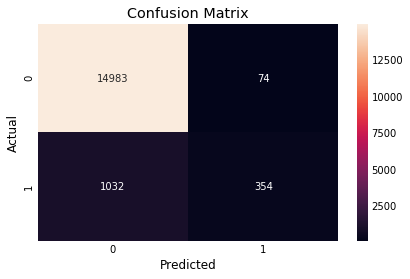

In [10]:
model = LogisticRegression()
model.fit(X_train,y_train)
prediction1=model.predict(X_valid)
print("__"*50,"\n")
print('The accuracy of the Logistic Regression is',metrics.accuracy_score(y_valid,prediction1))
print("__"*50,"\n")
print('The F1 score of the Logistic Regression is',metrics.f1_score(y_valid,prediction1))
print("__"*50,"\n")
print(classification_report(y_valid,prediction1))
print("__"*50)
sns.heatmap(confusion_matrix(y_valid,prediction1),annot=True,fmt="d")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

____________________________________________________________________________________________________ 

The accuracy of the Logistic Regression is 0.9157088122605364
____________________________________________________________________________________________________ 

The F1 score of the Logistic Regression is 0.0
____________________________________________________________________________________________________ 

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     15057
         1.0       0.00      0.00      0.00      1386

   micro avg       0.92      0.92      0.92     16443
   macro avg       0.46      0.50      0.48     16443
weighted avg       0.84      0.92      0.88     16443

____________________________________________________________________________________________________


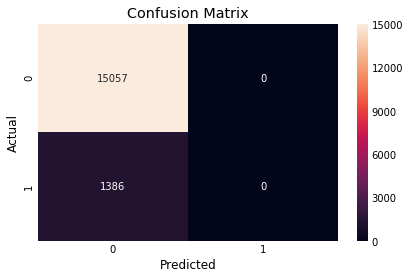

In [11]:
model = LogisticRegression()
model.fit(X_train[['avg_training_score']],y_train)
prediction1=model.predict(X_valid[['avg_training_score']])
print("__"*50,"\n")
print('The accuracy of the Logistic Regression is',metrics.accuracy_score(y_valid,prediction1))
print("__"*50,"\n")
print('The F1 score of the Logistic Regression is',metrics.f1_score(y_valid,prediction1))
print("__"*50,"\n")
print(classification_report(y_valid,prediction1))
print("__"*50)
sns.heatmap(confusion_matrix(y_valid,prediction1),annot=True,fmt="d")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

##### Observations
***
-  Still pretty high accuarcy with just 1 feature ('avg_training_score')
-  Precision =0 , Recall =0 for class 1
-  Issue because of class Imbalance
***

### Address Class Imbalance
***
Broadly there are 2 techniques to handle class Imbalance

**Resampling**
***
-  UnderSampling
-  OverSampling 
-  SMOTE

<br>**Algorithmic Ensemble Techniques**
***
-  Bagging
-  Boosting
-  class_weights='balanced'

We will be evealuating model based on precison , recall & AUCPR(Area under Precision Recall Curve)

### Resampling

In [12]:
cv = 10

lgr_clf    = LogisticRegression()
rf_clf = RandomForestClassifier()
ada_clf      = AdaBoostClassifier()

In [13]:
# Logistic regression score with Random Over-sampling
print("Random over-sampling")
score = resample_data(lgr_clf, X, y, cv, pr_auc_score, RandomOverSampler())
print("Cross-validated AUPRC score: %.2f"%score)

# Logistic regression score with SMOTE
print("SMOTE over-sampling")
score = resample_data(lgr_clf, X, y, cv, pr_auc_score, SMOTE())
print("Cross-validated AUPRC score: %.2f"%score)

# Logistic regression score with a
print("ADASYN over-sampling")
score = resample_data(lgr_clf, X, y, cv, pr_auc_score, ADASYN())
print("Cross-validated AUPRC score: %.2f"%score)

# Logistic regression score with Random Under Sampling
print("Random under-sampling")
score = resample_data(lgr_clf, X, y, cv, pr_auc_score, RandomUnderSampler())
print("Cross-validated AUPRC score: %.2f"%score)

Random over-sampling
Train AUPRC: 0.87 Test AUPRC: 0.47
Train AUPRC: 0.87 Test AUPRC: 0.50
Train AUPRC: 0.87 Test AUPRC: 0.45
Train AUPRC: 0.87 Test AUPRC: 0.49
Train AUPRC: 0.87 Test AUPRC: 0.45
Train AUPRC: 0.87 Test AUPRC: 0.47
Train AUPRC: 0.87 Test AUPRC: 0.48
Train AUPRC: 0.87 Test AUPRC: 0.49
Train AUPRC: 0.87 Test AUPRC: 0.49
Train AUPRC: 0.87 Test AUPRC: 0.45
Cross-validated AUPRC score: 0.48
SMOTE over-sampling
Train AUPRC: 0.88 Test AUPRC: 0.48
Train AUPRC: 0.88 Test AUPRC: 0.52
Train AUPRC: 0.88 Test AUPRC: 0.46
Train AUPRC: 0.88 Test AUPRC: 0.50
Train AUPRC: 0.88 Test AUPRC: 0.46
Train AUPRC: 0.88 Test AUPRC: 0.48
Train AUPRC: 0.88 Test AUPRC: 0.49
Train AUPRC: 0.88 Test AUPRC: 0.51
Train AUPRC: 0.88 Test AUPRC: 0.50
Train AUPRC: 0.88 Test AUPRC: 0.46
Cross-validated AUPRC score: 0.48
ADASYN over-sampling
Train AUPRC: 0.87 Test AUPRC: 0.47
Train AUPRC: 0.86 Test AUPRC: 0.52
Train AUPRC: 0.86 Test AUPRC: 0.45
Train AUPRC: 0.86 Test AUPRC: 0.50
Train AUPRC: 0.87 Test AUPRC: 

## Feature Engineering 

In [9]:
df_copy=df_full

In [10]:
df_copy['diff_from_avg_training_score_dept_mean'] = df_copy['avg_training_score'] - df_copy.groupby('department')['avg_training_score'].transform('mean')
df_copy['diff_from_avg_training_score_region_mean'] = df_copy['avg_training_score'] - df_copy.groupby('region')['avg_training_score'].transform('mean')
df_copy['age_by_position'] = pd.cut(x=df_copy['age'], bins=[0,25, 35, 40, 45,55,100], labels=['Very Young', 'Mid level', 'senior','lead','director','board'])

In [11]:
df_copy['age_by_position'] = pd.cut(x=df_copy['age'], bins=[0,25, 35, 40, 45,55,100], labels=['Very Young', 'Mid level', 'senior','lead','director','board'])

#### Prepare Data

In [12]:
num_features=['KPIs_met >80%', 'avg_training_score', 'awards_won?','length_of_service' ,'no_of_trainings', 'diff_from_avg_training_score_dept_mean','diff_from_avg_training_score_region_mean']
cat_features=['department', 'education', 'gender' ,'previous_year_rating','recruitment_channel', 'region','age_by_position']
X_train,X_valid,y_train,y_valid,X_test,X,y=prepare_data(df_copy,num_features,cat_features)

X_train: (38365, 70) X_valid: (16443, 70) y_train: (38365,) y_valid: (16443,)


____________________________________________________________________________________________________ 

The accuracy of the Logistic Regression is 0.9328589673417259
____________________________________________________________________________________________________ 

The F1 score of the Logistic Regression is 0.39999999999999997
____________________________________________________________________________________________________ 

              precision    recall  f1-score   support

         0.0       0.94      0.99      0.96     15057
         1.0       0.81      0.27      0.40      1386

   micro avg       0.93      0.93      0.93     16443
   macro avg       0.87      0.63      0.68     16443
weighted avg       0.93      0.93      0.92     16443

____________________________________________________________________________________________________


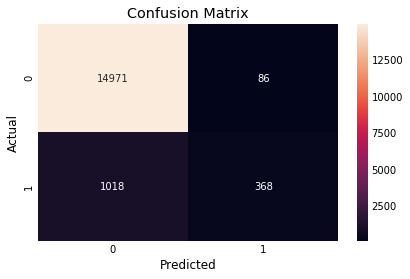

In [18]:
model = LogisticRegression()
model.fit(X_train,y_train)
prediction1=model.predict(X_valid)
print("__"*50,"\n")
print('The accuracy of the Logistic Regression is',metrics.accuracy_score(y_valid,prediction1))
print("__"*50,"\n")
print('The F1 score of the Logistic Regression is',metrics.f1_score(y_valid,prediction1))
print("__"*50,"\n")
print(classification_report(y_valid,prediction1))
print("__"*50)
sns.heatmap(confusion_matrix(y_valid,prediction1),annot=True,fmt="d")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [13]:
def resample_data_v3(clf, x, y, cv, scoring, sampler):
    '''
        This function computes the cross-validation score of a given 
        classifier using a choice of sampling function to mitigate 
        the class imbalance, and stratified k-fold sampling.
        
        The first five arguments are the same as 
        sklearn.model_selection.cross_val_score.
        
        - clf.predict_proba(x) returns class label probabilities
        - clf.fit(x,y) trains the model
        
        - x = data
        
        - y = labels
        
        - cv = the number of folds in the cross validation
        
        - scoring(classifier, x, y) returns a float
        
        The last argument is a choice of random sampler: an object 
        similar to the sampler objects available from the python 
        package imbalanced-learn. In particular, this 
        object needs to have the method:
        
        sampler.fit_sample(x,y)
        
    '''
    
    cv_score = 0.
    train_score = 0.
    test_score = 0.
    
    # stratified k-fold creates folds with the same ratio of positive 
    # and negative samples as the entire dataset.
    
    skf = StratifiedKFold(n_splits=cv, random_state=0, shuffle=False)
    
    for train_idx, test_idx in skf.split(x,y):
        #print(train_idx,test_idx)
        xfold_train_sampled, yfold_train_sampled = sampler.fit_sample(x.iloc[train_idx],y.iloc[train_idx])
        clf.fit(xfold_train_sampled, yfold_train_sampled)
        
        prediction1=clf.predict(x.iloc[test_idx])
        
        cv_score += metrics.f1_score(y.iloc[test_idx],prediction1)
        
    return cv_score/cv,clf
        

##### LR

In [20]:
# Logistic regression score with Random Over-sampling
print("Random over-sampling")
score,clf = resample_data_v3(lgr_clf, X, y, cv, pr_auc_score, RandomOverSampler())
print("Cross-validated F1 score: %.2f"%score)

# Logistic regression score with SMOTE
print("SMOTE over-sampling")
score,clf = resample_data_v3(lgr_clf, X, y, cv, pr_auc_score, SMOTE())
print("Cross-validated F1 score: %.2f"%score)

# Logistic regression score with a
print("ADASYN over-sampling")
score,clf = resample_data_v3(lgr_clf, X, y, cv, pr_auc_score, ADASYN())
print("Cross-validated F1 score: %.2f"%score)

# Logistic regression score with Random Under Sampling
print("Random under-sampling")
score,clf = resample_data_v3(lgr_clf, X, y, cv, pr_auc_score, RandomUnderSampler())
print("Cross-validated F1 score: %.2f"%score)

Random over-sampling
Cross-validated F1 score: 0.38
SMOTE over-sampling
Cross-validated F1 score: 0.38
ADASYN over-sampling
Cross-validated F1 score: 0.37
Random under-sampling
Cross-validated F1 score: 0.38


##### Observations:
***
-  SMOTE over-sampling have hightest score of Cross-validated AUPRC score: 0.38
-  Random under-sampling have the lowest value of 0.38 , which seems inplausible due to loss of information
***

### Test Data

In [41]:
X_test['is_promoted']=clf.predict(X_test)
submission=pd.read_csv("sample_submission.csv")
submission['is_promoted']=X_test['is_promoted']
submission['is_promoted']=submission['is_promoted'].astype(int)
submission[['employee_id','is_promoted']].to_csv("XGBoost_Submission4.csv",index=False)

In [80]:
***********

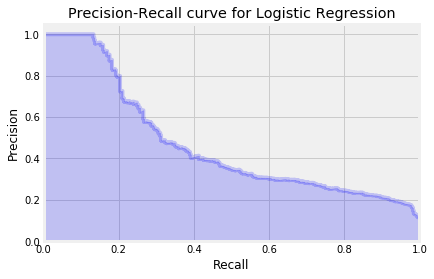

In [21]:
sampler = SMOTE()
skf = StratifiedKFold(n_splits=cv, random_state=0, shuffle=False)
clf = lgr_clf

train_idx, test_idx = skf.split(X,y).__next__()
#print(train_idx)
xfold_train_sampled, yfold_train_sampled = sampler.fit_sample(X.iloc[train_idx],y.iloc[train_idx])

clf.fit(xfold_train_sampled, yfold_train_sampled)

precisions, recalls,_ = precision_recall_curve(y.iloc[test_idx], clf.predict_proba(X.iloc[test_idx])[:,1], pos_label=1)

plt.step(recalls, precisions, color='b', alpha=0.2,
         where='post')
plt.fill_between(recalls, precisions, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve for Logistic Regression')
plt.show()

##### RF

In [25]:
# Random Forest regression score with Random Over-sampling
print("Random over-sampling")
score,clf_ros = resample_data_v3(rf_clf, X, y, cv, pr_auc_score, RandomOverSampler())
print("Cross-validated F1 score: %.2f"%score)

# Random Forest regression score with SMOTE
print("SMOTE over-sampling")
score,clf_smote = resample_data_v3(rf_clf, X, y, cv, pr_auc_score, SMOTE())
print("Cross-validated F1 score: %.2f"%score)

# Random Forest regression score with ADASYN
print("ADASYN over-sampling")
score,clf_adasyn = resample_data_v3(rf_clf, X, y, cv, pr_auc_score, ADASYN())
print("Cross-validated F1 score: %.2f"%score)

# Random Forest regression score with Random Under Sampling
print("Random under-sampling")
score,clf_rus = resample_data_v3(rf_clf, X, y, cv, pr_auc_score, RandomUnderSampler())
print("Cross-validated F1 score: %.2f"%score)

Random over-sampling
Cross-validated F1 score: 0.49
SMOTE over-sampling
Cross-validated F1 score: 0.49
ADASYN over-sampling
Cross-validated F1 score: 0.48
Random under-sampling
Cross-validated F1 score: 0.39


##### Observations:
***
-  Rest samplings have high F1 score than random under-sampling
-  Random Forest models seems to be doing better than Logistic Regression wrt F1 score
***

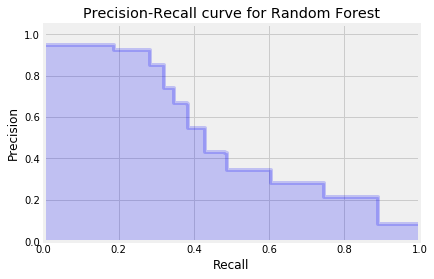

In [26]:
sampler = SMOTE()
skf = StratifiedKFold(n_splits=cv, random_state=0, shuffle=False)
clf = rf_clf

train_idx, test_idx = skf.split(X,y).__next__()
#print(train_idx)
xfold_train_sampled, yfold_train_sampled = sampler.fit_sample(X.iloc[train_idx],y.iloc[train_idx])

clf.fit(xfold_train_sampled, yfold_train_sampled)

precisions, recalls,_ = precision_recall_curve(y.iloc[test_idx], clf.predict_proba(X.iloc[test_idx])[:,1], pos_label=1)

plt.step(recalls, precisions, color='b', alpha=0.2,
         where='post')
plt.fill_between(recalls, precisions, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve for Random Forest')
plt.show()

##### Adaboost

In [27]:
# Random Forest regression score with Random Over-sampling
print("Random over-sampling")
score,clf_ros = resample_data_v3(ada_clf, X, y, cv, pr_auc_score, RandomOverSampler())
print("Cross-validated F1 score: %.2f"%score)

# Random Forest regression score with SMOTE
print("SMOTE over-sampling")
score,clf_smote = resample_data_v3(ada_clf, X, y, cv, pr_auc_score, SMOTE())
print("Cross-validated F1 score: %.2f"%score)

# Random Forest regression score with ADASYN
print("ADASYN over-sampling")
score,clf_adasyn = resample_data_v3(ada_clf, X, y, cv, pr_auc_score, ADASYN())
print("Cross-validated F1 score: %.2f"%score)

# Random Forest regression score with Random Under Sampling
print("Random under-sampling")
score,clf_rus = resample_data_v3(ada_clf, X, y, cv, pr_auc_score, RandomUnderSampler())
print("Cross-validated F1 score: %.2f"%score)

Random over-sampling
Cross-validated F1 score: 0.38
SMOTE over-sampling
Cross-validated F1 score: 0.41
ADASYN over-sampling
Cross-validated F1 score: 0.39
Random under-sampling
Cross-validated F1 score: 0.38


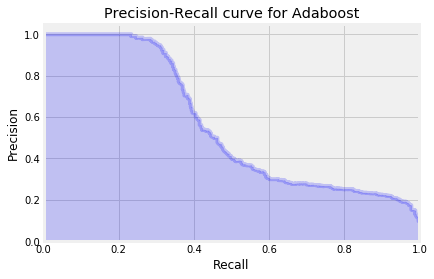

In [28]:
sampler = SMOTE()
skf = StratifiedKFold(n_splits=cv, random_state=0, shuffle=False)
clf = ada_clf

train_idx, test_idx = skf.split(X,y).__next__()
#print(train_idx)
xfold_train_sampled, yfold_train_sampled = sampler.fit_sample(X.iloc[train_idx],y.iloc[train_idx])

clf.fit(xfold_train_sampled, yfold_train_sampled)

precisions, recalls,_ = precision_recall_curve(y.iloc[test_idx], clf.predict_proba(X.iloc[test_idx])[:,1], pos_label=1)

plt.step(recalls, precisions, color='b', alpha=0.2,
         where='post')
plt.fill_between(recalls, precisions, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve for Adaboost')
plt.show()

##### Observations

- Adaboost AUPRC looks better than Logistic Regression but Random Forest are the best.

## Algorithmic Approach

#####  Logistic Regrssion using Weights

____________________________________________________________________________________________________ 

The accuracy of the Logistic Regression is 0.7765614547223743
____________________________________________________________________________________________________ 

The F1 score of the Logistic Regression is 0.3833501174890903
____________________________________________________________________________________________________ 

              precision    recall  f1-score   support

         0.0       0.98      0.77      0.86     15057
         1.0       0.25      0.82      0.38      1386

   micro avg       0.78      0.78      0.78     16443
   macro avg       0.61      0.80      0.62     16443
weighted avg       0.92      0.78      0.82     16443

____________________________________________________________________________________________________


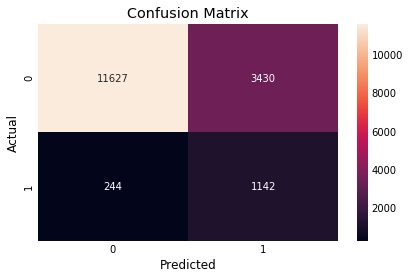

In [35]:
model = LogisticRegression(class_weight='balanced')
model.fit(X_train,y_train)
prediction3=model.predict(X_valid)
print("__"*50,"\n")
print('The accuracy of the Logistic Regression is',metrics.accuracy_score(prediction3,y_valid))
print("__"*50,"\n")
print('The F1 score of the Logistic Regression is',metrics.f1_score(prediction3,y_valid))
print("__"*50,"\n")
print(classification_report(y_valid,prediction3))
print("__"*50)
sns.heatmap(confusion_matrix(y_valid,prediction3),annot=True,fmt="d")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

##### Observations
***
-  Precision is low for 1 class in validation set
***

____________________________________________________________________________________________________ 

The accuracy of the Logistic Regression is 0.721097123395974
____________________________________________________________________________________________________ 

The F1 score of the Logistic Regression is 0.3549929676511955
____________________________________________________________________________________________________ 

              precision    recall  f1-score   support

         0.0       0.99      0.70      0.82     15057
         1.0       0.22      0.91      0.35      1386

   micro avg       0.72      0.72      0.72     16443
   macro avg       0.60      0.81      0.59     16443
weighted avg       0.92      0.72      0.78     16443

____________________________________________________________________________________________________


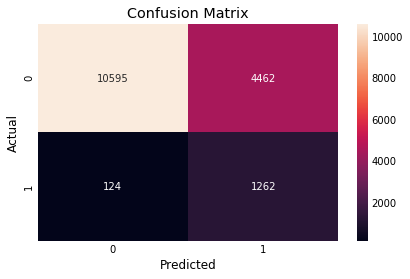

In [36]:
model = LogisticRegression(class_weight={1:0.95,0:0.05})
model.fit(X_train,y_train)
prediction3=model.predict(X_valid)
print("__"*50,"\n")
print('The accuracy of the Logistic Regression is',metrics.accuracy_score(prediction3,y_valid))
print("__"*50,"\n")
print('The F1 score of the Logistic Regression is',metrics.f1_score(prediction3,y_valid))
print("__"*50,"\n")
print(classification_report(y_valid,prediction3))
print("__"*50)
sns.heatmap(confusion_matrix(y_valid,prediction3),annot=True,fmt="d")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

##### Observations
***
-  For misclassifying 1 class ,loss function will be penalised by 0.95 whereas for misclassifying 0 
   class loss function with be penalised by 0.05
-  Precision is high for 1 class in validation set
-  Recall is high for 0 class in valiadtion set
-  Running GridSearchCV to find optiml weight for both classes
***

Best parameters : {'class_weight': {0: 0.28684210526315784, 1: 0.7131578947368422}}


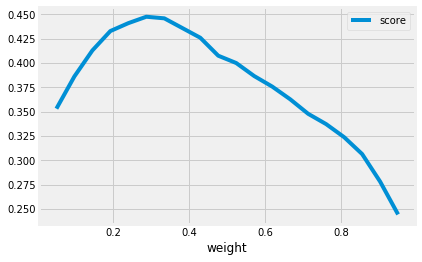

In [38]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import  make_scorer
pr_auc_scorer = make_scorer(pr_auc_score, greater_is_better=True,
                           needs_proba=True)

weights = np.linspace(0.05, 0.95, 20)

gsc = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid={
        'class_weight': [{0: x, 1: 1.0-x} for x in weights]
    },
    scoring='f1',
    cv=10
)
grid_result = gsc.fit(X, y)

print("Best parameters : %s" % grid_result.best_params_)

# Plot the weights vs f1 score
dataz = pd.DataFrame({ 'score': grid_result.cv_results_['mean_test_score'],
                       'weight': weights })
dataz.plot(x='weight')
plt.show()

____________________________________________________________________________________________________ 

The accuracy of the Logistic Regression is 0.9129720853858785
____________________________________________________________________________________________________ 

The F1 score of the Logistic Regression is 0.44642166344294004
____________________________________________________________________________________________________ 

              precision    recall  f1-score   support

         0.0       0.95      0.96      0.95     15057
         1.0       0.48      0.42      0.45      1386

   micro avg       0.91      0.91      0.91     16443
   macro avg       0.71      0.69      0.70     16443
weighted avg       0.91      0.91      0.91     16443

____________________________________________________________________________________________________


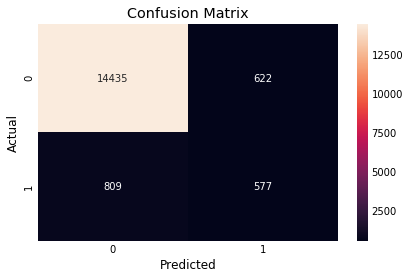

In [40]:
model = LogisticRegression(**grid_result.best_params_)
model.fit(X_train,y_train)
prediction3=model.predict(X_valid)
print("__"*50,"\n")
print('The accuracy of the Logistic Regression is',metrics.accuracy_score(prediction3,y_valid))
print("__"*50,"\n")
print('The F1 score of the Logistic Regression is',metrics.f1_score(prediction3,y_valid))
print("__"*50,"\n")
print(classification_report(y_valid,prediction3))
print("__"*50)
sns.heatmap(confusion_matrix(y_valid,prediction3),annot=True,fmt="d")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

##### Observations
***
-  As expected Recall improved but Precision degraded , The idea with class weigths is if we assign weight like {0:0.95,1:0.05} , it would mean to misclassify 0 it would be penalized heavily therefore we see high recall and low precsion
***

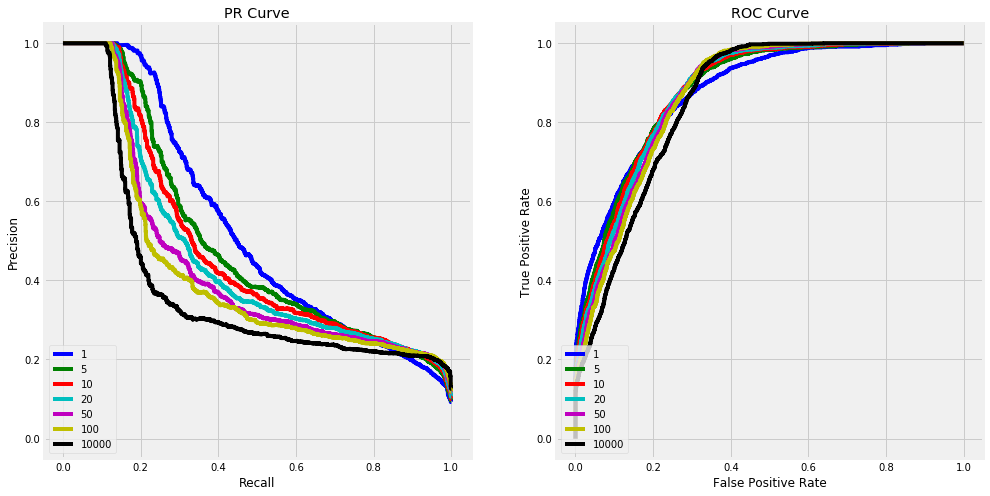

In [41]:
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlim([-0.05,1.05])
ax1.set_ylim([-0.05,1.05])
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('PR Curve')

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlim([-0.05,1.05])
ax2.set_ylim([-0.05,1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve')

for w,k in zip([1,5,10,20,50,100,10000],'bgrcmykw'):
    lr_model = LogisticRegression(class_weight={0:1,1:w})
    lr_model.fit(X_train,y_train)
    pred_prob = lr_model.predict_proba(X_valid)[:,1]

    p,r,_ = precision_recall_curve(y_valid,pred_prob)
    tpr,fpr,_ = roc_curve(y_valid,pred_prob)
    
    ax1.plot(r,p,c=k,label=w)
    ax2.plot(tpr,fpr,c=k,label=w)
ax1.legend(loc='lower left')    
ax2.legend(loc='lower left')

plt.show()

***
-  Never test on the oversampled or undersampled dataset.
-  If we want to implement cross validation, remember to oversample or undersample your training data during cross-validation, not before!
-  Don't use accuracy score as a metric with imbalanced datasets (will be usually high and misleading), instead use f1-score, precision/recall score or confusion matrix
***

## Logistic Regression 
***
Running GridSearchCV to find optimal value of C for logisticRegression while applying different Over/Under sampling techniques
***

In [42]:
def benchmark(sampling_type,X,y):
    lr = LogisticRegression(penalty = 'l1')
    param_grid = {'C':[0.01,0.1,1,10]}
    gs = GridSearchCV(estimator=lr, param_grid=param_grid, scoring='f1', cv=5, verbose=2)
    gs = gs.fit(X.values,y.values.ravel())
    return sampling_type,gs.best_score_,gs.best_params_['C']

def transform(transformer,X,y):
    print("Transforming {}".format(transformer.__class__.__name__))
    skf = StratifiedKFold(n_splits=5, random_state=0, shuffle=False)
    
    for train_idx, test_idx in skf.split(X,y):
        X_resampled,y_resampled = transformer.fit_sample(X.iloc[train_idx],y.iloc[train_idx])
    
    return transformer.__class__.__name__,pd.DataFrame(X_resampled), pd.DataFrame(y_resampled)

In [43]:
datasets = []
datasets.append(("base",X_train,y_train))
datasets.append(transform(SMOTE(n_jobs=-1),X_train,y_train))
datasets.append(transform(RandomOverSampler(),X_train,y_train))
#datasets.append(transform(ClusterCentroids(n_jobs=-1),X_train,y_train))
datasets.append(transform(NearMiss(n_jobs=-1),X_train,y_train))
datasets.append(transform(RandomUnderSampler(),X_train,y_train))
datasets.append(transform(SMOTEENN(),X_train,y_train))
datasets.append(transform(SMOTETomek(),X_train,y_train))

Transforming SMOTE
Transforming RandomOverSampler
Transforming NearMiss
Transforming RandomUnderSampler
Transforming SMOTEENN
Transforming SMOTETomek


In [44]:
benchmark_scores = []
for sample_type,X,y in datasets:
    print('______________________________________________________________')
    print('{}'.format(sample_type))
    benchmark_scores.append(benchmark(sample_type,X,y))
    print('______________________________________________________________')
    

______________________________________________________________
base
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] ........................................... C=0.01, total=   0.2s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.2s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.2s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.2s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.2s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   0.8s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   0.9s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  1.2min finished


______________________________________________________________
______________________________________________________________
SMOTE
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........................................... C=0.01, total=   0.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] ........................................... C=0.01, total=   0.5s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.5s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.6s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.5s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   4.6s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   3.8s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   3.2s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  1.0min finished


______________________________________________________________
______________________________________________________________
RandomOverSampler
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........................................... C=0.01, total=   0.3s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] ........................................... C=0.01, total=   0.3s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.3s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.3s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.3s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   2.2s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   1.8s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   2.2s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   38.7s finished


______________________________________________________________
______________________________________________________________
NearMiss
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.0s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.0s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.0s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.0s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.0s
[CV] C=0.1 ...........................................................
[CV] ...................

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ............................................ C=0.1, total=   0.0s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   0.0s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   0.0s
[CV] C=1 .............................................................
[CV] .............................................. C=1, total=   0.2s
[CV] C=1 .............................................................
[CV] .............................................. C=1, total=   0.2s
[CV] C=1 .............................................................
[CV] .............................................. C=1, total=   0.2s
[CV] C=1 .............................................................
[CV] .............................................. C=1, total=   0.3s
[CV] C=1 .............................................................
[CV] .

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    3.8s finished


______________________________________________________________
______________________________________________________________
RandomUnderSampler
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.0s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.0s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.0s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.0s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.0s
[CV] C=0.1 ...........................................................
[CV] .........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV] .............................................. C=1, total=   0.2s
[CV] C=1 .............................................................
[CV] .............................................. C=1, total=   0.2s
[CV] C=1 .............................................................
[CV] .............................................. C=1, total=   0.2s
[CV] C=1 .............................................................
[CV] .............................................. C=1, total=   0.3s
[CV] C=1 .............................................................
[CV] .............................................. C=1, total=   0.1s
[CV] C=10 ............................................................
[CV] ............................................. C=10, total=   0.2s
[CV] C=10 ............................................................
[CV] ............................................. C=10, total=   0.3s
[CV] C=10 ............................................................
[CV] 

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    2.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........................................... C=0.01, total=   0.3s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] ........................................... C=0.01, total=   0.3s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.3s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.3s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.3s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   2.4s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   2.4s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   2.4s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   24.6s finished


______________________________________________________________
______________________________________________________________
SMOTETomek
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........................................... C=0.01, total=   0.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] ........................................... C=0.01, total=   0.4s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.4s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.4s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.4s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   2.5s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   1.7s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   2.3s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  1.0min finished


______________________________________________________________


In [45]:
benchmark_scores

[('base', 0.4003119703582629, 1),
 ('SMOTE', 0.8137642964515142, 0.1),
 ('RandomOverSampler', 0.8007061383915703, 10),
 ('NearMiss', 0.7584845535210771, 1),
 ('RandomUnderSampler', 0.8025567967778134, 0.01),
 ('SMOTEENN', 0.9146227017637993, 0.1),
 ('SMOTETomek', 0.8140813221567895, 10)]

##### Observations

-  Different value of C for different methods with different accuracy

In [47]:
scores = []
# train models based on benchmark params
for sampling_type,score,param in benchmark_scores:
    print("Training on {}".format(sampling_type))
    lr = LogisticRegression(penalty = 'l1',C=param)
    for s_type,X,y in datasets:
        if s_type == sampling_type:
            lr.fit(X.values,y.values.ravel())
            pred_test = lr.predict(X_valid.values)
            pred_test_probs = lr.predict_proba(X_valid.values)
            probs = lr.decision_function(X_valid.values)
            fpr, tpr, thresholds = roc_curve(y_valid.values.ravel(),pred_test)
            p,r,t = precision_recall_curve(y_valid.values.ravel(),probs)
            scores.append((sampling_type,
                           f1_score(y_valid.values.ravel(),pred_test),
                           precision_score(y_valid.values.ravel(),pred_test),
                           recall_score(y_valid.values.ravel(),pred_test),
                           accuracy_score(y_valid.values.ravel(),pred_test),
                           auc(fpr, tpr),
                           auc(p,r,reorder=True),
                           confusion_matrix(y_valid.values.ravel(),pred_test)))

Training on base


/home/bhbhan/.conda/envs/newron_clone/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


Training on SMOTE


/home/bhbhan/.conda/envs/newron_clone/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


Training on RandomOverSampler


/home/bhbhan/.conda/envs/newron_clone/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


Training on NearMiss


/home/bhbhan/.conda/envs/newron_clone/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/bhbhan/.conda/envs/newron_clone/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


Training on RandomUnderSampler
Training on SMOTEENN


/home/bhbhan/.conda/envs/newron_clone/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


Training on SMOTETomek


/home/bhbhan/.conda/envs/newron_clone/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


In [48]:
sampling_results = pd.DataFrame(scores,columns=['Sampling Type','f1','precision','recall','accuracy','auc_roc','auc_pr','confusion_matrix'])
sampling_results['Model']='LogisticRegression'
sampling_results

,Sampling Type,f1,precision,recall,accuracy,auc_roc,auc_pr,confusion_matrix,Model
0,base,0.400435,0.814159,0.265512,0.932981,0.629967,0.443001,"[[14973, 84], [1018, 368]]",LogisticRegression
1,SMOTE,0.389312,0.257913,0.793651,0.790123,0.791725,0.386894,"[[11892, 3165], [286, 1100]]",LogisticRegression
2,RandomOverSampler,0.380391,0.248132,0.814574,0.776318,0.793686,0.375850,"[[11636, 3421], [257, 1129]]",LogisticRegression
3,NearMiss,0.147048,0.081820,0.725108,0.290944,0.488044,0.172442,"[[3779, 11278], [381, 1005]]",LogisticRegression
4,RandomUnderSampler,0.358168,0.227149,0.846320,0.744329,0.790630,0.359851,"[[11066, 3991], [213, 1173]]",LogisticRegression
5,SMOTEENN,0.358303,0.223739,0.898990,0.728578,0.805940,0.342146,"[[10734, 4323], [140, 1246]]",LogisticRegression
6,SMOTETomek,0.389924,0.258527,0.792929,0.790853,0.791796,0.385489,"[[11905, 3152], [287, 1099]]",LogisticRegression


##### Observations
***
-  Tried bunch of over/under sampling techniques
***

In [49]:
lr = LogisticRegression(penalty = 'l1',class_weight="balanced")
lr.fit(X_train.values,y_train.values.ravel())
scores = []
pred_test = lr.predict(X_valid.values)
pred_test_probs = lr.predict_proba(X_valid.values)
probs = lr.decision_function(X_valid.values)
fpr, tpr, thresholds = roc_curve(y_valid.values.ravel(),pred_test)
p,r,t = precision_recall_curve(y_valid.values.ravel(),probs)
scores.append(("weighted_base",
                           f1_score(y_valid.values.ravel(),pred_test),
                           precision_score(y_valid.values.ravel(),pred_test),
                           recall_score(y_valid.values.ravel(),pred_test),
                           accuracy_score(y_valid.values.ravel(),pred_test),
                           auc(fpr, tpr),
                           auc(p,r,reorder=True),
                           confusion_matrix(y_valid.values.ravel(),pred_test)))

scores = pd.DataFrame(scores,columns=['Sampling Type','f1','precision','recall','accuracy','auc_roc','auc_pr',\
                                      'confusion_matrix'])
scores['Model']='LogisticRegression'

/home/bhbhan/.conda/envs/newron_clone/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


In [50]:
results = sampling_results.append(scores)
results

,Sampling Type,f1,precision,recall,accuracy,auc_roc,auc_pr,confusion_matrix,Model
0,base,0.400435,0.814159,0.265512,0.932981,0.629967,0.443001,"[[14973, 84], [1018, 368]]",LogisticRegression
1,SMOTE,0.389312,0.257913,0.793651,0.790123,0.791725,0.386894,"[[11892, 3165], [286, 1100]]",LogisticRegression
2,RandomOverSampler,0.380391,0.248132,0.814574,0.776318,0.793686,0.375850,"[[11636, 3421], [257, 1129]]",LogisticRegression
3,NearMiss,0.147048,0.081820,0.725108,0.290944,0.488044,0.172442,"[[3779, 11278], [381, 1005]]",LogisticRegression
4,RandomUnderSampler,0.358168,0.227149,0.846320,0.744329,0.790630,0.359851,"[[11066, 3991], [213, 1173]]",LogisticRegression
5,SMOTEENN,0.358303,0.223739,0.898990,0.728578,0.805940,0.342146,"[[10734, 4323], [140, 1246]]",LogisticRegression
6,SMOTETomek,0.389924,0.258527,0.792929,0.790853,0.791796,0.385489,"[[11905, 3152], [287, 1099]]",LogisticRegression
0,weighted_base,0.383171,0.249563,0.824675,0.776197,0.798205,0.378323,"[[11620, 3437], [243, 1143]]",LogisticRegression


##### Observations
***

-  Above table is consolidated matrix of metrics for logistic Regression
***

## Random Forest
***
Running RandomCV to find optimal value of hyperparameters for Random Forest while applying different Over/Under sampling techniques
***

In [18]:
from sklearn.model_selection import RandomizedSearchCV

In [64]:
def benchmark(sampling_type,X,y):
    lr = RandomForestClassifier()
    param_grid = {
        'n_estimators': [100,150,200,300,400],
        'bootstrap': [True, False],
        'min_samples_leaf': [1, 2, 4],
        'min_samples_split': [2, 5, 10],
        'max_depth': [7,8,9,10]
        }
    gs = RandomizedSearchCV(estimator=lr, param_distributions=param_grid, scoring='f1', cv=5, verbose=2,n_jobs =-1)
    gs = gs.fit(X.values,y.values.ravel())
    return sampling_type,gs.best_score_,gs.best_params_['n_estimators'],gs.best_params_['bootstrap'],\
gs.best_params_['min_samples_leaf'],gs.best_params_['max_depth'],gs.best_params_['min_samples_split'] 

def transform(transformer,X,y):
    print("Transforming {}".format(transformer.__class__.__name__))
    skf = StratifiedKFold(n_splits=5, random_state=0, shuffle=False)
    
    for train_idx, test_idx in skf.split(X,y):
        X_resampled,y_resampled = transformer.fit_sample(X.iloc[train_idx],y.iloc[train_idx])
    
    return transformer.__class__.__name__,pd.DataFrame(X_resampled), pd.DataFrame(y_resampled)

In [55]:
datasets = []
datasets.append(("base",X_train,y_train))
datasets.append(transform(SMOTE(n_jobs=-1),X_train,y_train))
datasets.append(transform(RandomOverSampler(),X_train,y_train))
#datasets.append(transform(ClusterCentroids(n_jobs=-1),X_train,y_train))
datasets.append(transform(NearMiss(n_jobs=-1),X_train,y_train))
datasets.append(transform(RandomUnderSampler(),X_train,y_train))
datasets.append(transform(SMOTEENN(),X_train,y_train))
datasets.append(transform(SMOTETomek(),X_train,y_train))

Transforming SMOTE
Transforming RandomOverSampler
Transforming NearMiss
Transforming RandomUnderSampler
Transforming SMOTEENN
Transforming SMOTETomek


In [65]:
benchmark_scores = []
for sample_type,X,y in datasets:
    print('______________________________________________________________')
    print('{}'.format(sample_type))
    benchmark_scores.append(benchmark(sample_type,X,y))
    print('______________________________________________________________')
    

______________________________________________________________
base
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  50 | elapsed:   14.3s remaining:   19.8s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:   15.3s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   15.6s finished


______________________________________________________________
______________________________________________________________
SMOTE
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  50 | elapsed:   34.6s remaining:   47.8s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:   38.4s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   38.7s finished


______________________________________________________________
______________________________________________________________
RandomOverSampler
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  50 | elapsed:   22.1s remaining:   30.5s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:   26.2s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   26.2s finished


______________________________________________________________
______________________________________________________________
NearMiss
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  50 | elapsed:    1.0s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    1.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.8s finished


______________________________________________________________
______________________________________________________________
RandomUnderSampler
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  50 | elapsed:    1.9s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    2.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.5s finished


______________________________________________________________
______________________________________________________________
SMOTEENN
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  50 | elapsed:   20.6s remaining:   28.4s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:   25.1s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   25.3s finished


______________________________________________________________
______________________________________________________________
SMOTETomek
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  50 | elapsed:   40.2s remaining:   55.4s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:   42.8s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   43.0s finished


______________________________________________________________


In [66]:
benchmark_scores

[('base', 0.49379030015116865, 200, False, 1, 10, 10),
 ('SMOTE', 0.907273722332845, 400, False, 1, 10, 10),
 ('RandomOverSampler', 0.865962847226211, 150, False, 1, 10, 2),
 ('NearMiss', 0.750289128349985, 200, True, 4, 8, 10),
 ('RandomUnderSampler', 0.8353458312792118, 400, True, 1, 9, 10),
 ('SMOTEENN', 0.9485403209370858, 150, False, 2, 10, 5),
 ('SMOTETomek', 0.9058433631975363, 400, False, 4, 10, 10)]

In [69]:
scores = []
# train models based on benchmark params
for sampling_type,score,n_est,n_boot,min_sample_leaf,n_dep,min_sample_split in benchmark_scores:
    print("Training on {}".format(sampling_type))
    lr = RandomForestClassifier(n_estimators=n_est,min_samples_leaf =min_sample_leaf,bootstrap=n_boot,max_depth=n_dep,min_samples_split =min_sample_split)
    for s_type,X,y in datasets:
        if s_type == sampling_type:
            lr.fit(X.values,y.values.ravel())
            pred_test = lr.predict(X_valid.values)
            pred_test_probs = lr.predict_proba(X_valid.values)
            #probs = lr.decision_function(X_test.values)
            fpr, tpr, thresholds = roc_curve(y_valid.values.ravel(),pred_test)
            #p,r,t = precision_recall_curve(y_test.values.ravel(),probs)
            scores.append((sampling_type,
                           f1_score(y_valid.values.ravel(),pred_test),
                           precision_score(y_valid.values.ravel(),pred_test),
                           recall_score(y_valid.values.ravel(),pred_test),
                           accuracy_score(y_valid.values.ravel(),pred_test),
                           auc(fpr, tpr),
                           auc(p,r,reorder=True),
                           confusion_matrix(y_valid.values.ravel(),pred_test)))
            scores1 = pd.DataFrame(scores,columns=['Sampling Type','f1','precision','recall','accuracy','auc_roc','auc_pr',\
                                      'confusion_matrix'])
            scores1['Model']='RandomForest'
            

Training on base


/home/bhbhan/.conda/envs/newron_clone/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


Training on SMOTE


/home/bhbhan/.conda/envs/newron_clone/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


Training on RandomOverSampler


/home/bhbhan/.conda/envs/newron_clone/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


Training on NearMiss


/home/bhbhan/.conda/envs/newron_clone/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


Training on RandomUnderSampler


/home/bhbhan/.conda/envs/newron_clone/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


Training on SMOTEENN


/home/bhbhan/.conda/envs/newron_clone/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


Training on SMOTETomek


/home/bhbhan/.conda/envs/newron_clone/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


In [70]:
results = pd.concat([results,scores1])
results.drop_duplicates(subset=['Model','Sampling Type'],keep='first').reset_index(drop=True)

,Sampling Type,f1,precision,recall,accuracy,auc_roc,auc_pr,confusion_matrix,Model
0,base,0.400435,0.814159,0.265512,0.932981,0.629967,0.443001,"[[14973, 84], [1018, 368]]",LogisticRegression
1,SMOTE,0.389312,0.257913,0.793651,0.790123,0.791725,0.386894,"[[11892, 3165], [286, 1100]]",LogisticRegression
2,RandomOverSampler,0.380391,0.248132,0.814574,0.776318,0.793686,0.375850,"[[11636, 3421], [257, 1129]]",LogisticRegression
3,NearMiss,0.147048,0.081820,0.725108,0.290944,0.488044,0.172442,"[[3779, 11278], [381, 1005]]",LogisticRegression
4,RandomUnderSampler,0.358168,0.227149,0.846320,0.744329,0.790630,0.359851,"[[11066, 3991], [213, 1173]]",LogisticRegression
5,SMOTEENN,0.358303,0.223739,0.898990,0.728578,0.805940,0.342146,"[[10734, 4323], [140, 1246]]",LogisticRegression
6,SMOTETomek,0.389924,0.258527,0.792929,0.790853,0.791796,0.385489,"[[11905, 3152], [287, 1099]]",LogisticRegression
7,weighted_base,0.383171,0.249563,0.824675,0.776197,0.798205,0.378323,"[[11620, 3437], [243, 1143]]",LogisticRegression
8,base,0.520085,0.972332,0.354978,0.944779,0.677024,0.378323,"[[15043, 14], [894, 492]]",RandomForest
9,SMOTE,0.415601,0.294918,0.703463,0.833242,0.774326,0.378323,"[[12726, 2331], [411, 975]]",RandomForest


##### Observations:
***
-  Consoldated list of evauation metric for Logistic Regression & Random Forest.
-  Random Forest base accuracy is highest with decent precision & recall followed by Random Forest + SMOTE
***

____________________________________________________________________________________________________ 

The accuracy of the Random Forest is 0.9445964848263699
____________________________________________________________________________________________________ 

The F1 of the Random Forest is 0.5172231054583996
____________________________________________________________________________________________________ 

              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97     15057
         1.0       0.97      0.35      0.52      1386

   micro avg       0.94      0.94      0.94     16443
   macro avg       0.96      0.68      0.74     16443
weighted avg       0.95      0.94      0.93     16443

____________________________________________________________________________________________________


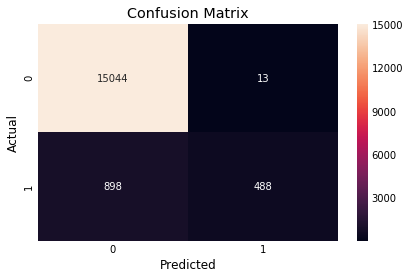

In [73]:
model = RandomForestClassifier(n_estimators=400,
    min_samples_leaf=1,bootstrap=False,max_depth=10,min_samples_split=10)
model.fit(X_train,y_train)
prediction1=model.predict(X_valid)
print("__"*50,"\n")
print('The accuracy of the Random Forest is',metrics.accuracy_score(y_valid,prediction1))
print("__"*50,"\n")
print('The F1 of the Random Forest is',metrics.f1_score(y_valid,prediction1))
print("__"*50,"\n")
print(classification_report(y_valid,prediction1))
print("__"*50)
sns.heatmap(confusion_matrix(y_valid,prediction1),annot=True,fmt="d")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

##### Observations
***
-  Trying Random Forest + SMOTE method
***

____________________________________________________________________________________________________ 

The accuracy of the Random Forest is 0.8640758985586572
____________________________________________________________________________________________________ 

The F1 of the Random Forest is 0.44111027756939236
____________________________________________________________________________________________________ 

              precision    recall  f1-score   support

         0.0       0.96      0.89      0.92     15057
         1.0       0.34      0.64      0.44      1386

   micro avg       0.86      0.86      0.86     16443
   macro avg       0.65      0.76      0.68     16443
weighted avg       0.91      0.86      0.88     16443

____________________________________________________________________________________________________


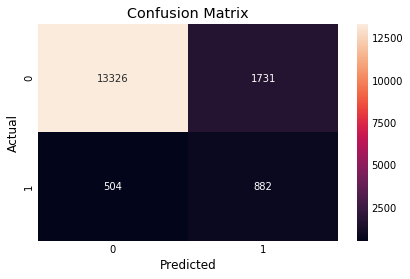

In [74]:
sampler = SMOTE()
skf = StratifiedKFold(n_splits=cv, random_state=0, shuffle=False)

clf = RandomForestClassifier(n_estimators=400,
    min_samples_leaf=1,bootstrap=False,max_depth=10,min_samples_split=10)

train_idx, test_idx = skf.split(X_train,y_train).__next__()
#print(train_idx)
xfold_train_sampled, yfold_train_sampled = sampler.fit_sample(X.iloc[train_idx],y.iloc[train_idx])
clf.fit(xfold_train_sampled, yfold_train_sampled)

prediction1=clf.predict(X_valid)

print("__"*50,"\n")
print('The accuracy of the Random Forest is',metrics.accuracy_score(y_valid,prediction1))
print("__"*50,"\n")
print('The F1 of the Random Forest is',metrics.f1_score(y_valid,prediction1))
print("__"*50,"\n")
print(classification_report(y_valid,prediction1))
print("__"*50)
sns.heatmap(confusion_matrix(y_valid,prediction1),annot=True,fmt="d")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

##### Observations
***
- Base Random Forest works well
***

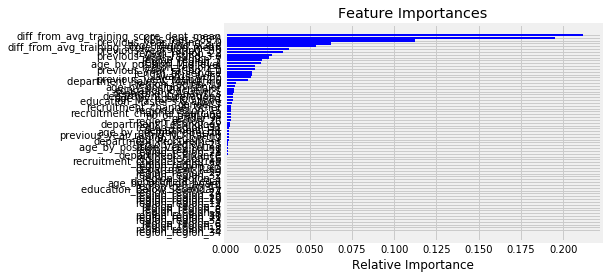

In [78]:
importances = clf.feature_importances_
indices = np.argsort(importances)

features = X_valid.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()

### XGBoost

In [14]:
from xgboost import XGBClassifier

In [15]:
def benchmark(sampling_type,X,y):
    lr = XGBClassifier()
    param_grid = {
        'n_estimators': [10,50,100,150,200,300],
        'min_child_weight': [3,4],
        'gamma':  [0],
        'subsample': [ 0.7, 0.8],
        'colsample_bytree': [ 0.7, 0.8],
        'max_depth': [7,8],
        'learning_rate' : [ 0.05, 0.1]
        }
    gs = RandomizedSearchCV(estimator=lr, param_distributions=param_grid, scoring='f1', cv=5, verbose=2,n_jobs =-1)
    gs = gs.fit(X.values,y.values.ravel())
    return sampling_type,gs.best_score_,gs.best_params_['n_estimators'],gs.best_params_['min_child_weight'],\
gs.best_params_['gamma'],gs.best_params_['subsample'],gs.best_params_['colsample_bytree'],gs.best_params_['max_depth'],gs.best_params_['learning_rate'], 

def transform(transformer,X,y):
    print("Transforming {}".format(transformer.__class__.__name__))
    skf = StratifiedKFold(n_splits=5, random_state=0, shuffle=False)
    
    for train_idx, test_idx in skf.split(X,y):
        X_resampled,y_resampled = transformer.fit_sample(X.iloc[train_idx],y.iloc[train_idx])
    
    return transformer.__class__.__name__,pd.DataFrame(X_resampled), pd.DataFrame(y_resampled)

In [16]:
datasets = []
datasets.append(("base",X_train,y_train))
datasets.append(transform(SMOTE(n_jobs=-1),X_train,y_train))
datasets.append(transform(RandomOverSampler(),X_train,y_train))
#datasets.append(transform(ClusterCentroids(n_jobs=-1),X_train,y_train))
datasets.append(transform(NearMiss(n_jobs=-1),X_train,y_train))
datasets.append(transform(RandomUnderSampler(),X_train,y_train))
datasets.append(transform(SMOTEENN(),X_train,y_train))
datasets.append(transform(SMOTETomek(),X_train,y_train))

Transforming SMOTE
Transforming RandomOverSampler
Transforming NearMiss
Transforming RandomUnderSampler
Transforming SMOTEENN
Transforming SMOTETomek


In [19]:
benchmark_scores = []
for sample_type,X,y in datasets:
    print('______________________________________________________________')
    print('{}'.format(sample_type))
    benchmark_scores.append(benchmark(sample_type,X,y))
    print('______________________________________________________________')

______________________________________________________________
base
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  50 | elapsed:   24.5s remaining:   33.8s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:   42.1s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   43.3s finished


______________________________________________________________
______________________________________________________________
SMOTE
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  50 | elapsed:   12.5s remaining:   17.3s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:   50.5s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   51.7s finished


______________________________________________________________
______________________________________________________________
RandomOverSampler
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  50 | elapsed:   38.6s remaining:   53.3s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:  1.2min remaining:    4.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.2min finished


______________________________________________________________
______________________________________________________________
NearMiss
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  50 | elapsed:    2.2s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    5.8s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    5.8s finished


______________________________________________________________
______________________________________________________________
RandomUnderSampler
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  50 | elapsed:    1.6s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    5.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    5.3s finished


______________________________________________________________
______________________________________________________________
SMOTEENN
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  50 | elapsed:   30.1s remaining:   41.6s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:   49.8s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   50.4s finished


______________________________________________________________
______________________________________________________________
SMOTETomek
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  50 | elapsed:   23.2s remaining:   32.0s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:   57.8s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   58.0s finished


______________________________________________________________


In [20]:
benchmark_scores

[('base', 0.5088199158808895, 200, 3, 0, 0.7, 0.7, 8, 0.1),
 ('SMOTE', 0.9576019889515904, 200, 3, 0, 0.7, 0.8, 8, 0.1),
 ('RandomOverSampler', 0.9383475274403424, 300, 4, 0, 0.7, 0.8, 8, 0.1),
 ('NearMiss', 0.7564476024136162, 150, 4, 0, 0.7, 0.8, 7, 0.05),
 ('RandomUnderSampler', 0.8367844400264097, 50, 3, 0, 0.7, 0.7, 8, 0.05),
 ('SMOTEENN', 0.9660178282689188, 200, 3, 0, 0.8, 0.8, 8, 0.05),
 ('SMOTETomek', 0.9575849316692833, 300, 3, 0, 0.7, 0.7, 8, 0.05)]

In [24]:
scores = []
# train models based on benchmark params
for sampling_type,score,n_est,min_child_weight,gamma,subsample,colsample_bytree,max_depth,learning_rate in benchmark_scores:
    print("Training on {}".format(sampling_type))
    lr = XGBClassifier(n_estimators=n_est,min_child_weight=min_child_weight,gamma=gamma,subsample=subsample,colsample_bytree=colsample_bytree,max_depth=max_depth,learning_rate=learning_rate)
    for s_type,X,y in datasets:
        if s_type == sampling_type:
            lr.fit(X.values,y.values.ravel())
            pred_test = lr.predict(X_valid.values)
            pred_test_probs = lr.predict_proba(X_valid.values)
            #probs = lr.decision_function(X_test.values)
            fpr, tpr, thresholds = roc_curve(y_valid.values.ravel(),pred_test)
            #p,r,t = precision_recall_curve(y_valid.values.ravel(),probs)
            scores.append((sampling_type,
                           f1_score(y_valid.values.ravel(),pred_test),
                           precision_score(y_valid.values.ravel(),pred_test),
                           recall_score(y_valid.values.ravel(),pred_test),
                           accuracy_score(y_valid.values.ravel(),pred_test),
                           auc(fpr, tpr),
                           0,
                           confusion_matrix(y_valid.values.ravel(),pred_test)))
            scores1 = pd.DataFrame(scores,columns=['Sampling Type','f1','precision','recall','accuracy','auc_roc','auc_pr',\
                                      'confusion_matrix'])
            scores1['Model']='XgBoost'
            

Training on base
Training on SMOTE
Training on RandomOverSampler
Training on NearMiss
Training on RandomUnderSampler
Training on SMOTEENN
Training on SMOTETomek


In [25]:
results = pd.concat([results,scores1])
results.drop_duplicates(subset=['Model','Sampling Type'],keep='first').reset_index(drop=True)

NameError: name 'results' is not defined

____________________________________________________________________________________________________ 

The accuracy of the Random Forest is 0.9433801617709664
____________________________________________________________________________________________________ 

The F1 of the Random Forest is 0.5281297516472377
____________________________________________________________________________________________________ 

              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97     15057
         1.0       0.89      0.38      0.53      1386

   micro avg       0.94      0.94      0.94     16443
   macro avg       0.92      0.69      0.75     16443
weighted avg       0.94      0.94      0.93     16443

____________________________________________________________________________________________________


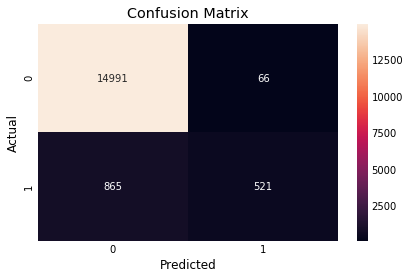

In [38]:
model = XGBClassifier(n_estimators=200,min_child_weight=3,gamma=0,subsample=0.7,colsample_bytree=0.8,max_depth=8,learning_rate=0.1)
model.fit(X_train,y_train)
prediction1=model.predict(X_valid)
print("__"*50,"\n")
print('The accuracy of the Random Forest is',metrics.accuracy_score(y_valid,prediction1))
print("__"*50,"\n")
print('The F1 of the Random Forest is',metrics.f1_score(y_valid,prediction1))
print("__"*50,"\n")
print(classification_report(y_valid,prediction1))
print("__"*50)
sns.heatmap(confusion_matrix(y_valid,prediction1),annot=True,fmt="d")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

____________________________________________________________________________________________________ 

The accuracy of the Random Forest is 0.941494861035091
____________________________________________________________________________________________________ 

The F1 of the Random Forest is 0.5228174603174602
____________________________________________________________________________________________________ 

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     15057
         1.0       0.84      0.38      0.52      1386

   micro avg       0.94      0.94      0.94     16443
   macro avg       0.89      0.69      0.75     16443
weighted avg       0.94      0.94      0.93     16443

____________________________________________________________________________________________________


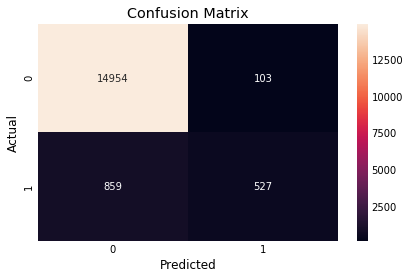

In [48]:
sampler = SMOTE()
skf = StratifiedKFold(n_splits=5, random_state=0, shuffle=False)

clf =  XGBClassifier(n_estimators=200,min_child_weight=3,subsample=0.7,colsample_bytree=0.8,max_depth=8,learning_rate=0.1)

train_idx, test_idx = skf.split(X_train,y_train).__next__()
#print(train_idx)
xfold_train_sampled, yfold_train_sampled = sampler.fit_sample(X.iloc[train_idx],y.iloc[train_idx])
clf.fit(xfold_train_sampled, yfold_train_sampled)
prediction1=clf.predict(X_valid.as_matrix())

print("__"*50,"\n")
print('The accuracy of the Random Forest is',metrics.accuracy_score(y_valid,prediction1))
print("__"*50,"\n")
print('The F1 of the Random Forest is',metrics.f1_score(y_valid,prediction1))
print("__"*50,"\n")
print(classification_report(y_valid,prediction1))
print("__"*50)
sns.heatmap(confusion_matrix(y_valid,prediction1),annot=True,fmt="d")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
X_test['is_promoted']=clf.predict(X_test)
submission=pd.read_csv("sample_submission.csv")
submission['is_promoted']=X_test['is_promoted']
submission['is_promoted']=submission['is_promoted'].astype(int)
submission[['employee_id','is_promoted']].to_csv("XGBoost_Submission4.csv",index=False)

### More Feature Engineering

In [49]:
df_copy=df_full

#### Difference between training score of individual with comapny's, dept, region, dept-region eompployees

In [51]:
df_copy['diff_from_avg_training_score_company'] = df_copy['avg_training_score'] - df_copy['avg_training_score'].mean()
df_copy['diff_from_avg_training_score_dept_mean'] = df_copy['avg_training_score'] - df_copy.groupby('department')['avg_training_score'].transform('mean')
df_copy['diff_from_avg_training_score_region_mean'] = df_copy['avg_training_score'] - df_copy.groupby('region')['avg_training_score'].transform('mean')
df_copy['diff_from_avg_training_score_dept_region_mean'] = df_copy['avg_training_score'] - df_copy.groupby(['region','department'])['avg_training_score'].transform('mean')

#### Difference between training score of individual with gender, gender-dept, gende-region, dept-region-gender eompployees

In [52]:
df_copy['diff_from_avg_training_score_gender_mean'] = df_copy['avg_training_score'] - df_copy.groupby('gender')['avg_training_score'].transform('mean')
df_copy['diff_from_avg_training_score_gender_region_mean'] = df_copy['avg_training_score'] - df_copy.groupby(['gender','region'])['avg_training_score'].transform('mean')
df_copy['diff_from_avg_training_score_gender_dept_mean'] = df_copy['avg_training_score'] - df_copy.groupby(['department','gender'])['avg_training_score'].transform('mean')
df_copy['diff_from_avg_training_score_dept_gender_region_dept_mean'] = df_copy['avg_training_score'] - df_copy.groupby(['region','gender','department'])['avg_training_score'].transform('mean')

#### converting age into categories of probable titles

In [53]:
df_copy['age_by_position'] = pd.cut(x=df_copy['age'], bins=[0,25, 35, 40, 45,55,100], labels=['Very Young', 'Mid level', 'senior','lead','director','board'])

#### Difference between training score of individual with age, age-dept, age-region, age-dept-region eompployees

In [54]:
df_copy['diff_from_avg_training_score_age_mean'] = df_copy['avg_training_score'] - df_copy.groupby('age_by_position')['avg_training_score'].transform('mean')
df_copy['diff_from_avg_training_score_age_region_mean'] = df_copy['avg_training_score'] - df_copy.groupby(['age_by_position','region'])['avg_training_score'].transform('mean')
df_copy['diff_from_avg_training_score_age_dept_mean'] = df_copy['avg_training_score'] - df_copy.groupby(['department','age_by_position'])['avg_training_score'].transform('mean')
df_copy['diff_from_avg_training_score_dept_age_region_dept_mean'] = df_copy['avg_training_score'] - df_copy.groupby(['region','age_by_position','department'])['avg_training_score'].transform('mean')

#### Difference between no. of trainings of individual with comapny's, dept, region, dept-region eompployees

In [55]:
df_copy['diff_from_no_of_trainings_company'] = df_copy['no_of_trainings'] - df_copy['no_of_trainings'].mean()
df_copy['diff_from_no_of_trainings_dept_mean'] = df_copy['no_of_trainings'] - df_copy.groupby('department')['no_of_trainings'].transform('mean')
df_copy['diff_from_no_of_trainings_region_mean'] = df_copy['no_of_trainings'] - df_copy.groupby('region')['no_of_trainings'].transform('mean')
df_copy['diff_from_no_of_trainings_dept_region_mean'] = df_copy['no_of_trainings'] - df_copy.groupby(['region','department'])['no_of_trainings'].transform('mean')

#### Difference between no. of trainings of individual with gender, gender-dept, gender-region, gender-dept-region eompployees

In [56]:
df_copy['diff_from_no_of_trainings_gender_mean'] = df_copy['no_of_trainings'] - df_copy.groupby('gender')['no_of_trainings'].transform('mean')
df_copy['diff_from_no_of_trainings_gender_region_mean'] = df_copy['no_of_trainings'] - df_copy.groupby(['gender','region'])['no_of_trainings'].transform('mean')
df_copy['diff_from_no_of_trainings_gender_dept_mean'] = df_copy['no_of_trainings'] - df_copy.groupby(['department','gender'])['no_of_trainings'].transform('mean')
df_copy['diff_from_no_of_trainings_dept_gender_region_dept_mean'] = df_copy['no_of_trainings'] - df_copy.groupby(['region','gender','department'])['no_of_trainings'].transform('mean')

#### Difference between no. of trainings of individual with age, age-dept, age-region, age-dept-region eompployees

In [57]:
df_copy['diff_from_no_of_trainings_age_mean'] = df_copy['no_of_trainings'] - df_copy.groupby('age_by_position')['no_of_trainings'].transform('mean')
df_copy['diff_from_no_of_trainings_age_region_mean'] = df_copy['no_of_trainings'] - df_copy.groupby(['age_by_position','region'])['no_of_trainings'].transform('mean')
df_copy['diff_from_no_of_trainings_age_dept_mean'] = df_copy['no_of_trainings'] - df_copy.groupby(['department','age_by_position'])['no_of_trainings'].transform('mean')
df_copy['diff_from_no_of_trainings_dept_age_region_dept_mean'] = df_copy['no_of_trainings'] - df_copy.groupby(['region','age_by_position','department'])['no_of_trainings'].transform('mean')

In [58]:
num_features=['KPIs_met >80%', 'avg_training_score', 'awards_won?','length_of_service' ,'no_of_trainings','diff_from_avg_training_score_company','diff_from_avg_training_score_dept_mean','diff_from_avg_training_score_region_mean',
             'diff_from_avg_training_score_dept_region_mean','diff_from_avg_training_score_gender_mean','diff_from_avg_training_score_gender_region_mean','diff_from_avg_training_score_gender_dept_mean','diff_from_avg_training_score_dept_gender_region_dept_mean',             'diff_from_avg_training_score_age_mean','diff_from_avg_training_score_age_region_mean','diff_from_avg_training_score_age_dept_mean','diff_from_avg_training_score_dept_age_region_dept_mean',\
             'diff_from_no_of_trainings_company','diff_from_no_of_trainings_dept_mean','diff_from_no_of_trainings_region_mean','diff_from_no_of_trainings_dept_region_mean','diff_from_no_of_trainings_gender_mean',
             'diff_from_no_of_trainings_gender_region_mean','diff_from_no_of_trainings_gender_dept_mean','diff_from_no_of_trainings_dept_gender_region_dept_mean','diff_from_no_of_trainings_age_mean',
             'diff_from_no_of_trainings_age_region_mean','diff_from_no_of_trainings_age_dept_mean','diff_from_no_of_trainings_dept_age_region_dept_mean']
cat_features=['department', 'education', 'gender' ,'previous_year_rating','recruitment_channel', 'region','age_by_position']

In [59]:
X_train,X_valid,y_train,y_valid,X_test,X,y=prepare_data(df_copy,num_features,cat_features)

X_train: (38365, 92) X_valid: (16443, 92) y_train: (38365,) y_valid: (16443,)


____________________________________________________________________________________________________ 

The accuracy of the XGBoost is 0.9389405826187436
____________________________________________________________________________________________________ 

The F1 of the XGboost is 0.5214489990467112
____________________________________________________________________________________________________ 

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     15057
         1.0       0.77      0.39      0.52      1386

   micro avg       0.94      0.94      0.94     16443
   macro avg       0.86      0.69      0.74     16443
weighted avg       0.93      0.94      0.93     16443

____________________________________________________________________________________________________


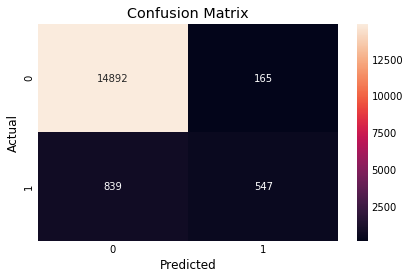

In [65]:
model = XGBClassifier(n_estimators=500,min_child_weight=3,gamma=0,subsample=0.7,colsample_bytree=0.8,max_depth=7,learning_rate=0.1)
model.fit(X_train,y_train)
prediction1=model.predict(X_valid)
print("__"*50,"\n")
print('The accuracy of the XGBoost is',metrics.accuracy_score(y_valid,prediction1))
print("__"*50,"\n")
print('The F1 of the XGboost is',metrics.f1_score(y_valid,prediction1))
print("__"*50,"\n")
print(classification_report(y_valid,prediction1))
print("__"*50)
sns.heatmap(confusion_matrix(y_valid,prediction1),annot=True,fmt="d")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()